In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

df_train = pd.read_csv('train.csv')
print('The shape of training set is', df_train.shape)

df_train.head()

The shape of training set is (159571, 8)


id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [2]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [3]:
df_train.describe().transpose()

count      mean       std  min  25%  50%  75%  max
toxic          159571.0  0.095844  0.294379  0.0  0.0  0.0  0.0  1.0
severe_toxic   159571.0  0.009996  0.099477  0.0  0.0  0.0  0.0  1.0
obscene        159571.0  0.052948  0.223931  0.0  0.0  0.0  0.0  1.0
threat         159571.0  0.002996  0.054650  0.0  0.0  0.0  0.0  1.0
insult         159571.0  0.049364  0.216627  0.0  0.0  0.0  0.0  1.0
identity_hate  159571.0  0.008805  0.093420  0.0  0.0  0.0  0.0  1.0

In [4]:
df_train[['comment_text']].describe(include = np.object).transpose()

count  unique                              top freq
comment_text  159571  159571  (hopefully i had them for free)    1

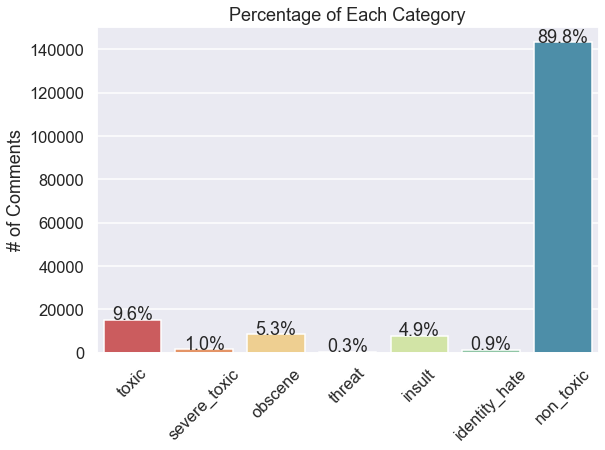

In [5]:
sns.set(style="darkgrid")
sns.set_context("talk")

rowsums=df_train.iloc[:,2:].sum(axis=1)
df_train['non_toxic']=(rowsums==0).astype(int)
x = df_train.iloc[:,2:].sum()
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=("Spectral"))
plt.xticks(rotation=45)
total = float(len(df_train))
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            percentage,
            ha="center") 
plt.title("Percentage of Each Category")
plt.ylabel('# of Comments')
plt.show()

In [6]:
# toxicity = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# level = []
# label = []
# count_sum = []
# for name in toxicity:
#     count = df_train[name].value_counts()
#     level.append(name)
#     label.append(count.index[0])
#     count_sum.append(count.values[0])
#     level.append(name)
#     label.append(count.index[1])
#     count_sum.append(count.values[1])
    
# # print(count.values[0]/(count.values[0] + count.values[1]))
# plt.figure(figsize=(9,6))
# sns.barplot(level, count_sum, hue = label, palette=("Blues_d"))
# plt.xticks(rotation=90)
# plt.title("Number of 0/1 for Each Category")
# plt.show()


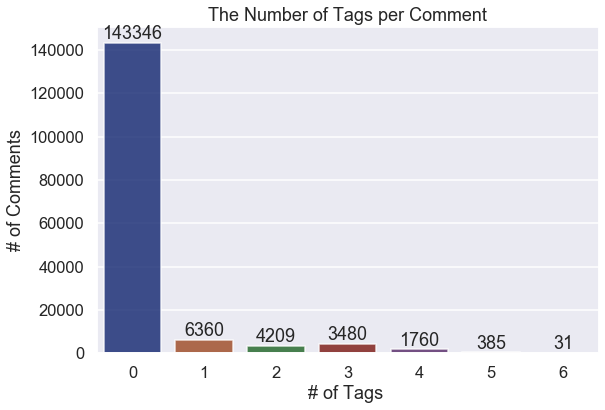

In [7]:

x=rowsums.value_counts()
#plot
plt.figure(figsize=(9,6))
ax = sns.barplot(x.index, x.values, alpha=0.8, palette=("dark"))
plt.title("The Number of Tags per Comment")
plt.ylabel('# of Comments')
plt.xlabel('# of Tags ')

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

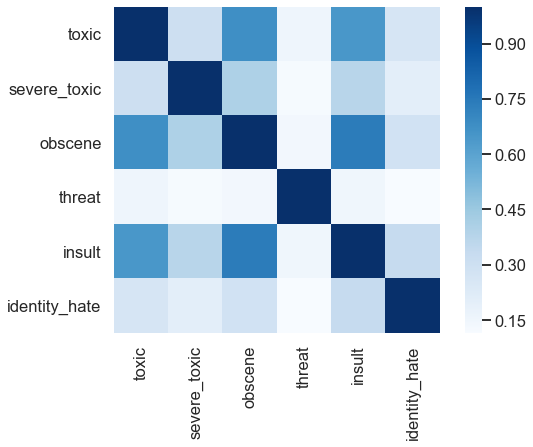

In [8]:
corr = df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
plt.subplots(figsize=(9,6))
sns.heatmap(corr, square=True, cmap='Blues')

In [9]:
df_train['toxic_vs_severe'] = df_train['toxic'] * df_train['severe_toxic']
df_train['toxic_vs_obscene'] = df_train['toxic'] * df_train['obscene']
df_train['toxic_vs_threat'] = df_train['toxic'] * df_train['threat']
df_train['toxic_vs_insult'] = df_train['toxic'] * df_train['insult']
df_train['toxic_vs_hate'] = df_train['toxic'] * df_train['identity_hate']
print('Percentage of severe_toxic comments are classified as toxic:', df_train['toxic_vs_severe'].sum()/df_train['severe_toxic'].sum() *100)
print('Percentage of obscene comments are classified as toxic:', df_train['toxic_vs_obscene'].sum()/df_train['obscene'].sum() *100)
print('Percentage of threat comments are classified as toxic:', df_train['toxic_vs_threat'].sum()/df_train['threat'].sum() *100)
print('Percentage of insult comments are classified as toxic:', df_train['toxic_vs_insult'].sum()/df_train['insult'].sum() *100)
print('Percentage of identity_hate comments are classified as toxic:', df_train['toxic_vs_hate'].sum()/df_train['identity_hate'].sum() *100)


Percentage of severe_toxic comments are classified as toxic: 100.0
Percentage of obscene comments are classified as toxic: 93.80991833353059
Percentage of threat comments are classified as toxic: 93.93305439330544
Percentage of insult comments are classified as toxic: 93.23346451694808
Percentage of identity_hate comments are classified as toxic: 92.66903914590748


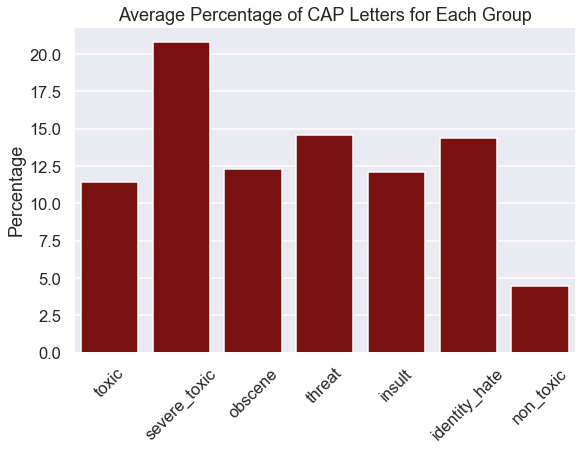

In [10]:
## Count the average percentage of CAP letters for each category
df_train['cap_letters_percentage'] = df_train['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper())/len(x)*100)
toxicity = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
average_ptage = []
for name in toxicity:
    average_ptage.append(df_train[df_train[name]==1]['cap_letters_percentage'].mean())

plt.figure(figsize=(9,6))
plt.xticks(rotation=45)
sns.barplot(x=toxicity, y=average_ptage, color="darkred")
plt.ylabel('Percentage')
plt.title('Average Percentage of CAP Letters for Each Group')
plt.show()


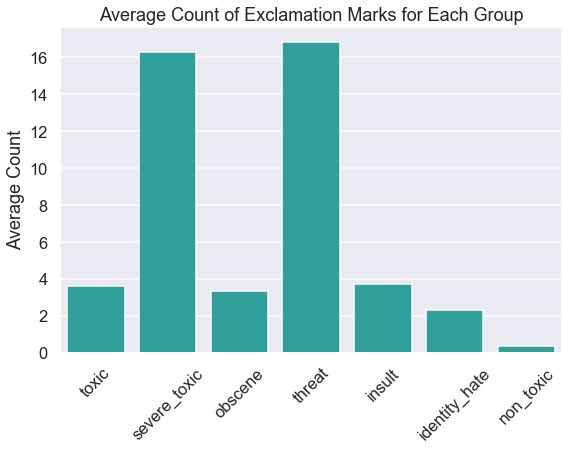

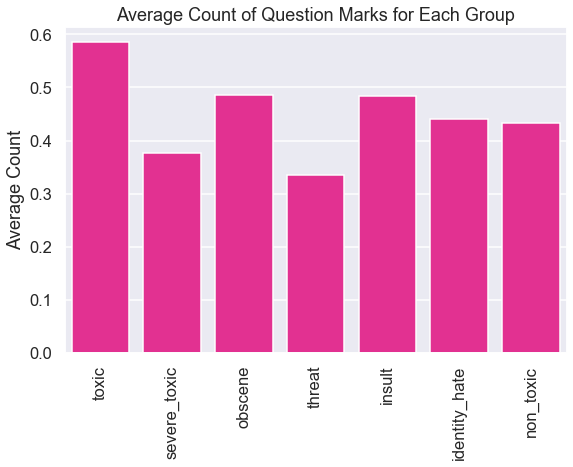

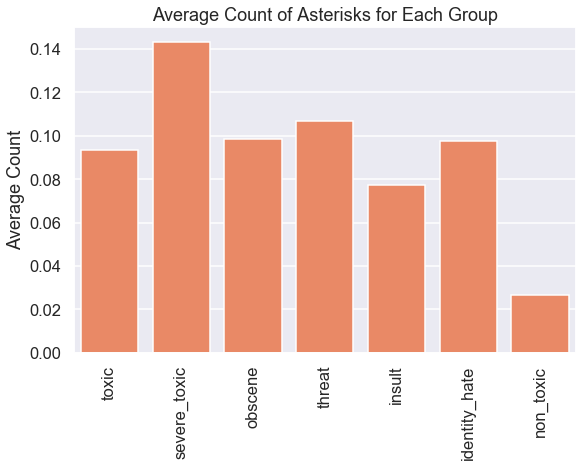

In [11]:
## Compute the average number of special characters !?* in each group
df_train['count_exclamation_mark'] = df_train['comment_text'].apply(lambda x: x.count('!'))
df_train['count_question_mark'] = df_train['comment_text'].apply(lambda x: x.count('?'))
df_train['count_asterisk'] = df_train['comment_text'].apply(lambda x: x.count('*'))
exclamation_mark = []
question_mark = []
asterisk = []
for name in toxicity:
    exclamation_mark.append(df_train[df_train[name]==1]['count_exclamation_mark'].mean())
    question_mark.append(df_train[df_train[name]==1]['count_question_mark'].mean())
    asterisk.append(df_train[df_train[name]==1]['count_asterisk'].mean())

plt.figure(figsize=(9,6))
plt.xticks(rotation=45)
sns.barplot(x=toxicity, y=exclamation_mark, color="lightseagreen")
plt.ylabel('Average Count')
plt.title('Average Count of Exclamation Marks for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=question_mark, color="deeppink")
plt.ylabel('Average Count')
plt.title('Average Count of Question Marks for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=asterisk, color="coral")
plt.ylabel('Average Count')
plt.title('Average Count of Asterisks for Each Group')
plt.show()


In [12]:
## Do the first clean-up on special characters and cap letters as we will explore the text properties
def clean_txt(raw_txt):

    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_txt) 
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             
    #
    # 3. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( words )) 


df_train['comment_text'] = df_train.comment_text.apply(clean_txt)
df_train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  explanation why the edits made under my userna...      0   
1  000103f0d9cfb60f  d aww he matches this background colour i m se...      0   
2  000113f07ec002fd  hey man i m really not trying to edit war it s...      0   
3  0001b41b1c6bb37e  more i can t make any real suggestions on impr...      0   
4  0001d958c54c6e35  you sir are my hero any chance you remember wh...      0   

   severe_toxic  obscene  threat  insult  identity_hate  non_toxic  \
0             0        0       0       0              0          1   
1             0        0       0       0              0          1   
2             0        0       0       0              0          1   
3             0        0       0       0              0          1   
4             0        0       0       0              0          1   

   toxic_vs_severe  toxic_vs_obscene  toxic_vs_threat  toxic_vs_insult  \
0                0                 0                0                0   
1                0                 0                0                0   
2                0                 0                0                0   
3                0                 0                0                0   
4                0                 0                0                0   

   toxic_vs_hate  cap_letters_percentage  count_exclamation_mark  \
0              0                6.439394                       0   
1              0                7.142857                       1   
2              0                1.716738                       0   
3              0                1.768489                       0   
4              0                2.985075                       0   

   count_question_mark  count_asterisk  
0                    1               0  
1                    0               0  
2                    0               0  
3                    0               0  
4                    1               0

In [13]:
df_train['sentiment'] = df_train['comment_text'].map(lambda text: TextBlob(text).sentiment.polarity)
df_train['text_len'] = df_train['comment_text'].astype(str).apply(len)
df_train['word_count'] = df_train['comment_text'].apply(lambda x: len(str(x).split()))
df_train['count_unique_word']=df_train["comment_text"].apply(lambda x: len(set(str(x).split())))
df_train['word_unique_percent']=df_train['count_unique_word']*100/df_train['word_count']


In [14]:
df_train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  explanation why the edits made under my userna...      0   
1  000103f0d9cfb60f  d aww he matches this background colour i m se...      0   
2  000113f07ec002fd  hey man i m really not trying to edit war it s...      0   
3  0001b41b1c6bb37e  more i can t make any real suggestions on impr...      0   
4  0001d958c54c6e35  you sir are my hero any chance you remember wh...      0   

   severe_toxic  obscene  threat  insult  identity_hate  non_toxic  \
0             0        0       0       0              0          1   
1             0        0       0       0              0          1   
2             0        0       0       0              0          1   
3             0        0       0       0              0          1   
4             0        0       0       0              0          1   

   toxic_vs_severe  ...  toxic_vs_hate  cap_letters_percentage  \
0                0  ...              0                6.439394   
1                0  ...              0                7.142857   
2                0  ...              0                1.716738   
3                0  ...              0                1.768489   
4                0  ...              0                2.985075   

   count_exclamation_mark  count_question_mark  count_asterisk  sentiment  \
0                       0                    1               0   0.136364   
1                       1                    0               0   0.250000   
2                       0                    0               0   0.160000   
3                       0                    0               0   0.255556   
4                       0                    1               0   0.000000   

   text_len  word_count  count_unique_word  word_unique_percent  
0       248          46                 42            91.304348  
1        88          16                 16           100.000000  
2       229          44                 41            93.181818  
3       601         116                 82            70.689655  
4        63          14                 13            92.857143  

[5 rows x 23 columns]

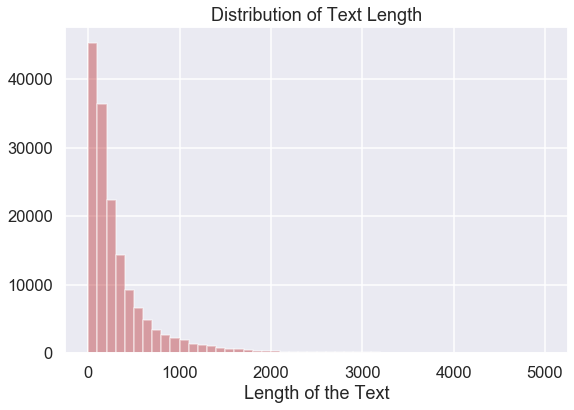

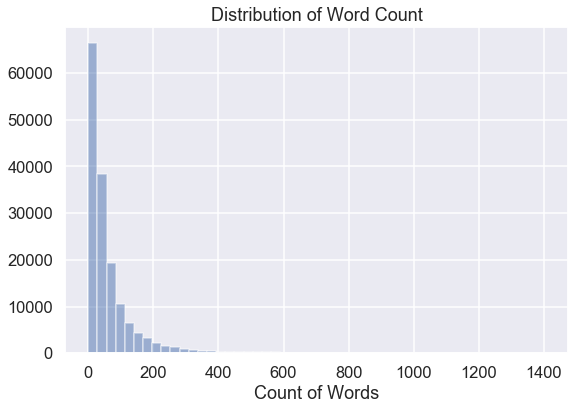

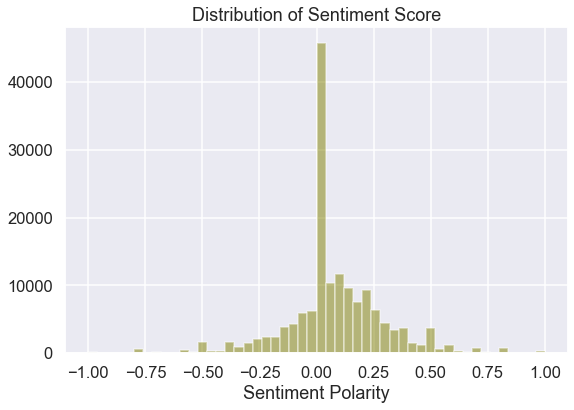

In [15]:
plt.figure(figsize=(9,6))
plt.hist(df_train['text_len'],bins=50, alpha=0.5, color='r')
plt.xlabel('Length of the Text')
plt.title('Distribution of Text Length')
plt.show()
plt.figure(figsize=(9,6))
plt.hist(df_train['word_count'],bins=50, alpha=0.5, label='no', color='b')
plt.xlabel('Count of Words')
plt.title('Distribution of Word Count')
plt.show()
plt.figure(figsize=(9,6))
plt.hist(df_train['sentiment'],bins=50, alpha=0.5, label='no', color='olive')
plt.xlabel('Sentiment Polarity')
plt.title('Distribution of Sentiment Score')
plt.show()


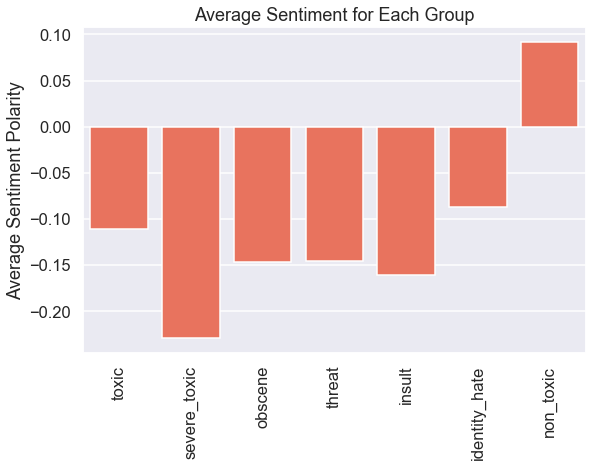

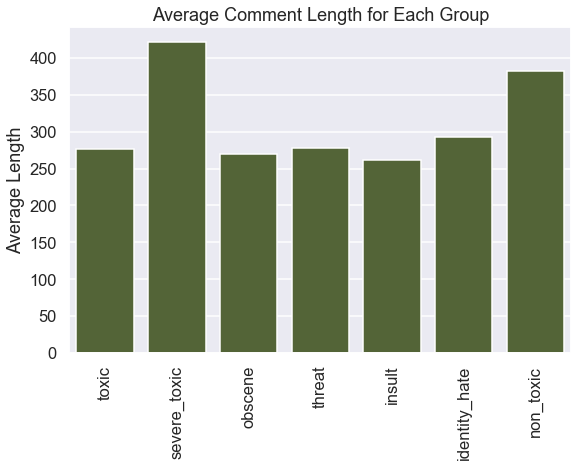

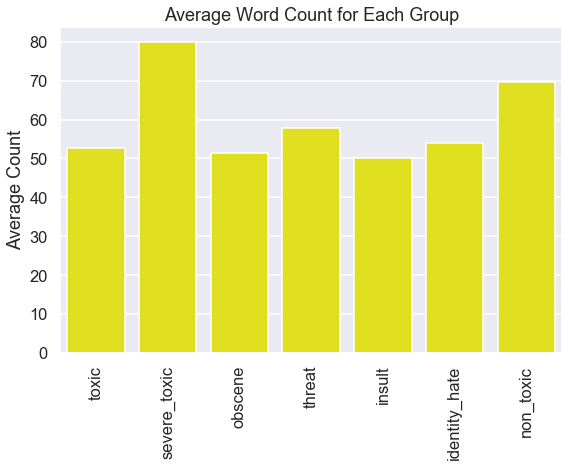

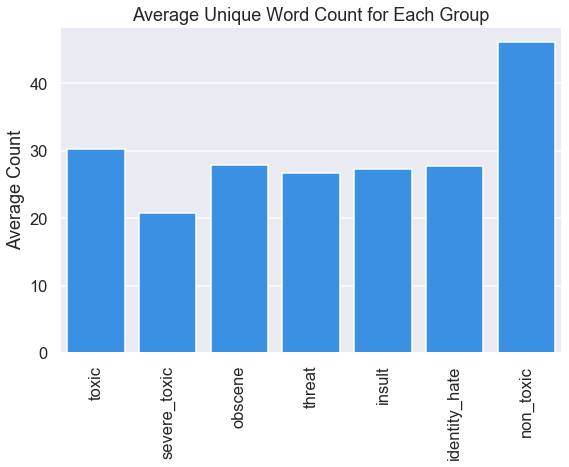

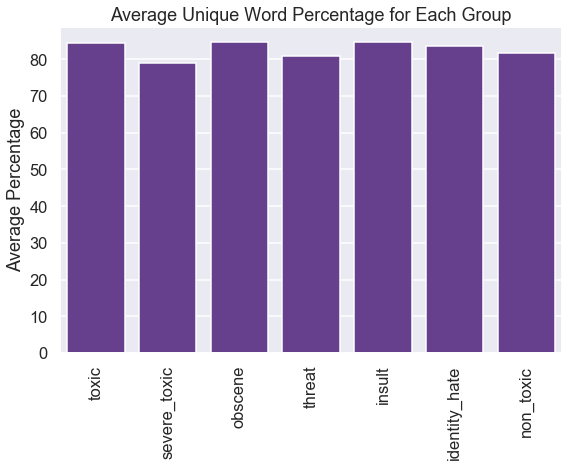

In [16]:
sentiment=[]
text_len=[]
word_count=[]
count_unique_word=[]
word_unique_ptage=[]
for name in toxicity:
    sentiment.append(df_train[df_train[name]==1]['sentiment'].mean())
    text_len.append(df_train[df_train[name]==1]['text_len'].mean())
    word_count.append(df_train[df_train[name]==1]['word_count'].mean())
    count_unique_word.append(df_train[df_train[name]==1]['count_unique_word'].mean())
    word_unique_ptage.append(df_train[df_train[name]==1]['word_unique_percent'].mean())

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=sentiment, color="tomato")
plt.ylabel('Average Sentiment Polarity')
plt.title('Average Sentiment for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=text_len, color="darkolivegreen")
plt.ylabel('Average Length')
plt.title('Average Comment Length for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=word_count, color="yellow")
plt.ylabel('Average Count')
plt.title('Average Word Count for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=count_unique_word, color="dodgerblue")
plt.ylabel('Average Count')
plt.title('Average Unique Word Count for Each Group')
plt.show()

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=toxicity, y=word_unique_ptage, color="rebeccapurple")
plt.ylabel('Average Percentage')
plt.title('Average Unique Word Percentage for Each Group')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


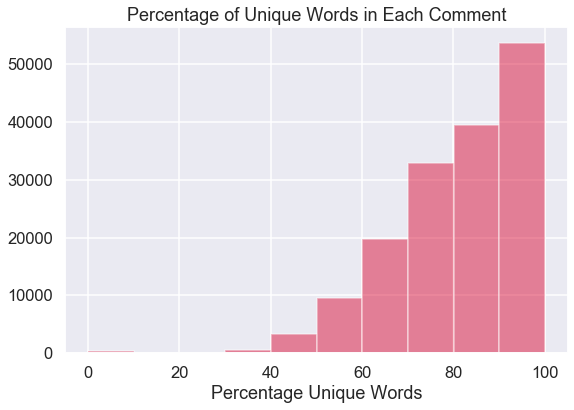

/Users/candicezhang/Library/Python/3.7/lib/python/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/candicezhang/Library/Python/3.7/lib/python/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


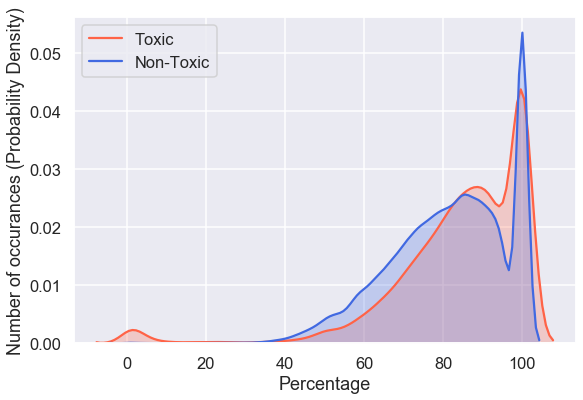

In [17]:
plt.figure(figsize=(9,6))
plt.hist(df_train['word_unique_percent'], alpha=0.5, label='no', color='crimson')
plt.xlabel('Percentage Unique Words')
plt.title('Percentage of Unique Words in Each Comment')
plt.show()
plt.figure(figsize=(9,6))
ax=sns.kdeplot(df_train[df_train['non_toxic'] == 0].word_unique_percent, label="Toxic",shade=True,color='tomato')
ax=sns.kdeplot(df_train[df_train['non_toxic'] == 1].word_unique_percent, label="Non-Toxic", shade = True, color = 'royalblue')
plt.legend()
plt.ylabel('Number of occurances (Probability Density)')
plt.xlabel('Percentage')
plt.show()

In [18]:
# correlation = df_train[['sentiment', 'text_len', 'word_count']]
# mask = np.zeros_like(correlation, dtype = np.bool)
# mask[np.triu_indices_from(mask)] = True
# plt.figure(figsize=(50,30))
# plt.xticks(fontsize = 40)
# plt.yticks(fontsize = 40)
# sns.heatmap(correlation, cmap = 'coolwarm', annot = True, annot_kws={'size':40}, linewidths=10, vmin=-1.5,mask=mask)

In [19]:
from collections import Counter
import string
word_counter = {}
# stop = stopwords.words('english')

# def clean_text(text):
#     text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
#     return ' '.join([word for word in text.split() if word not in (stop)])
toxicity = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
for categ in toxicity:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

## Word Cloud on original text

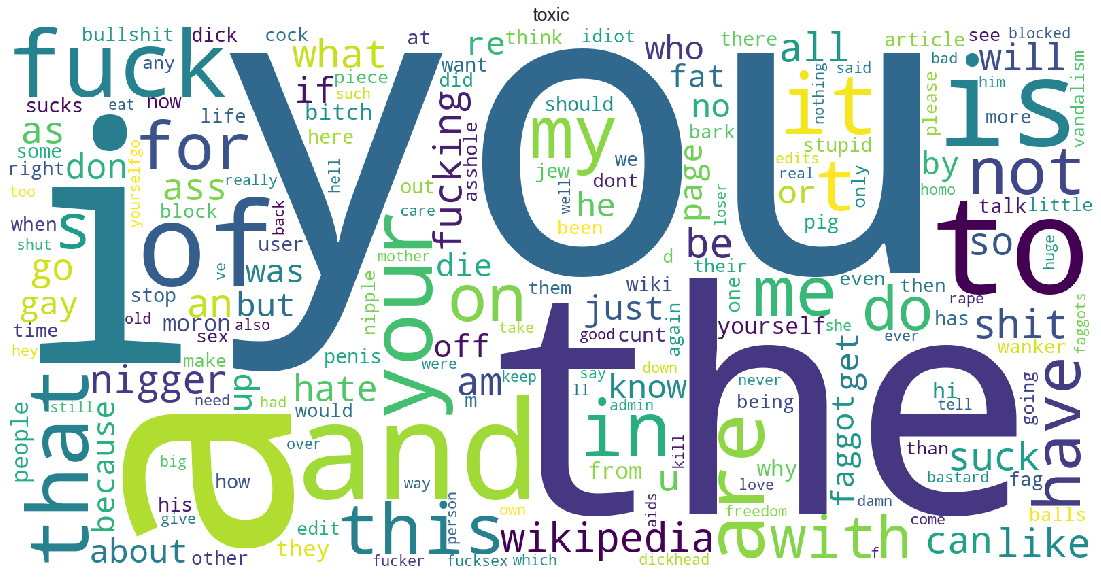

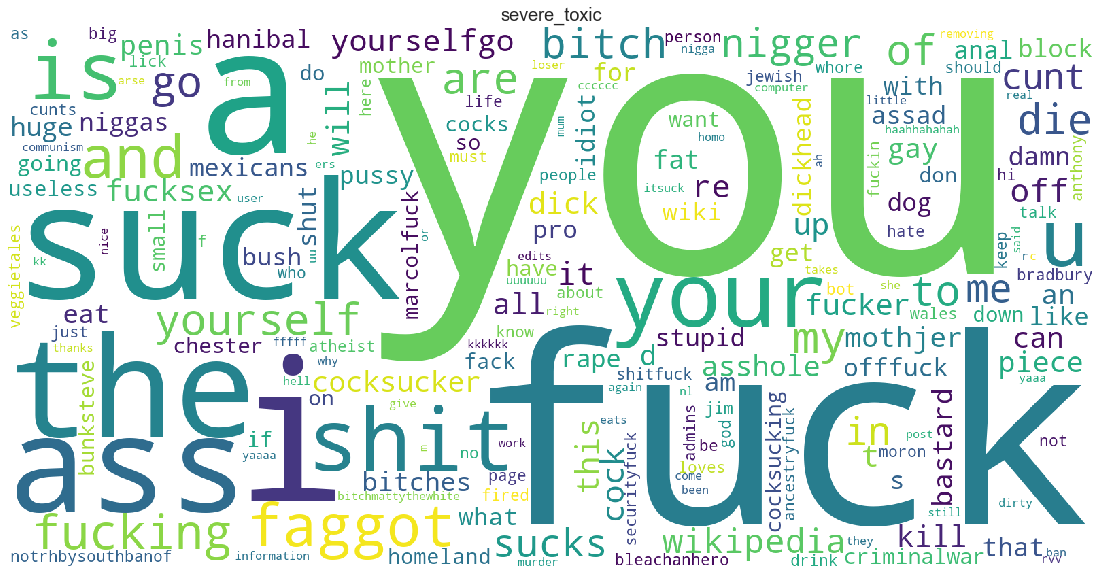

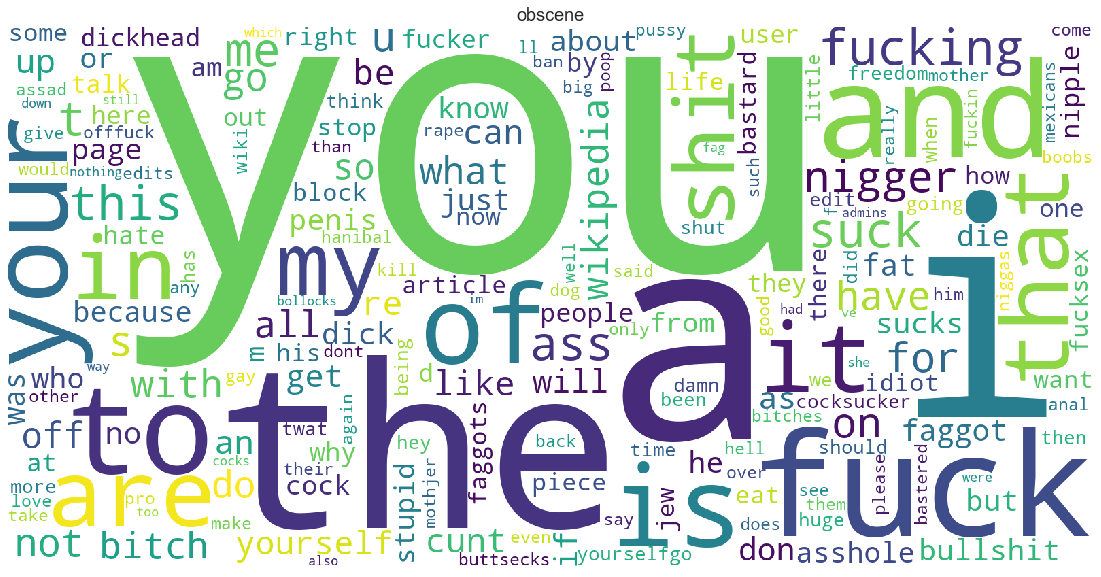

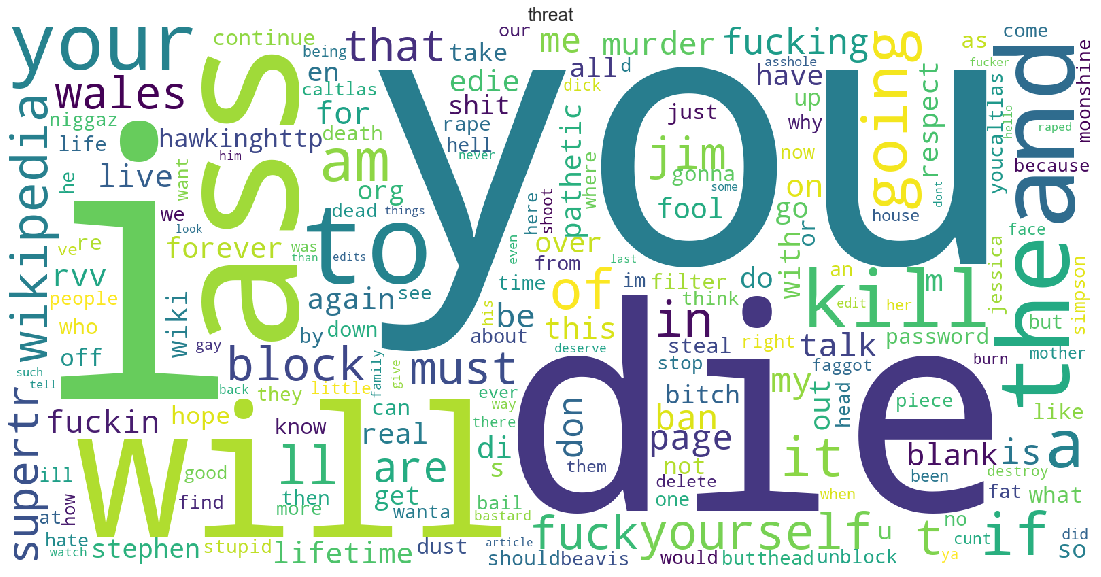

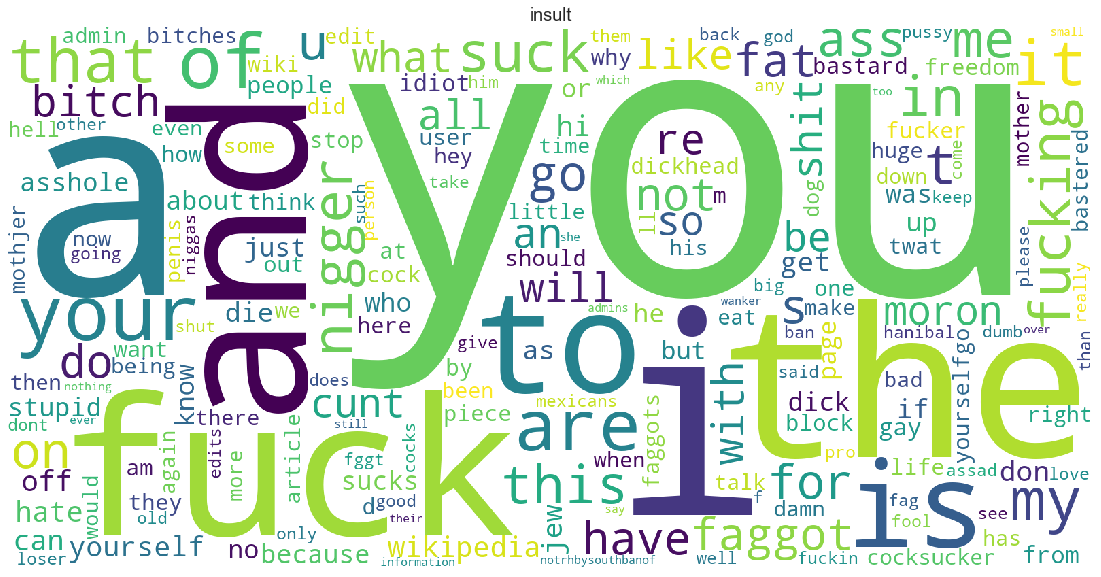

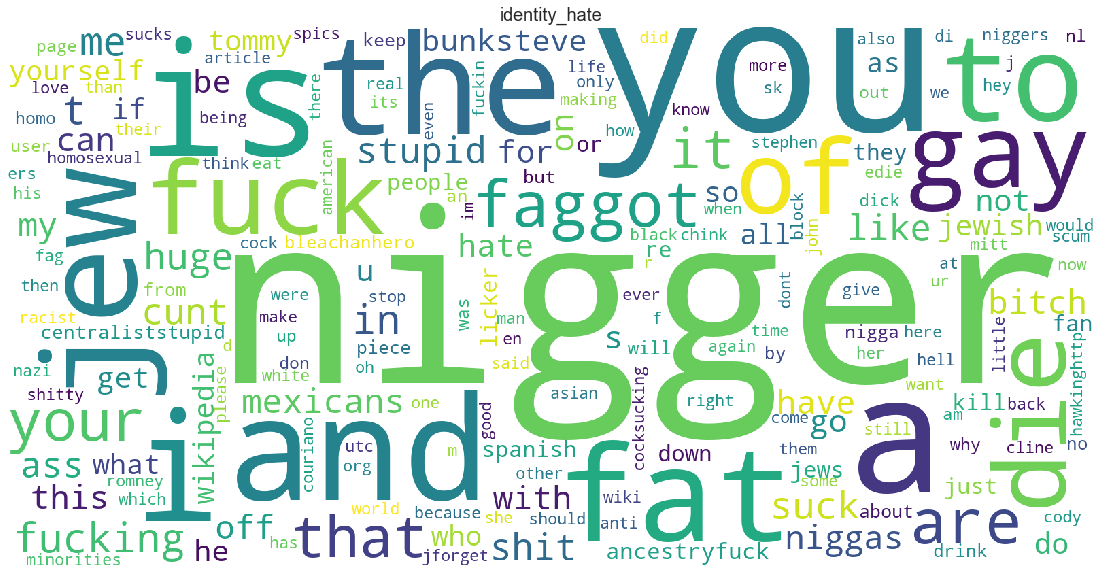

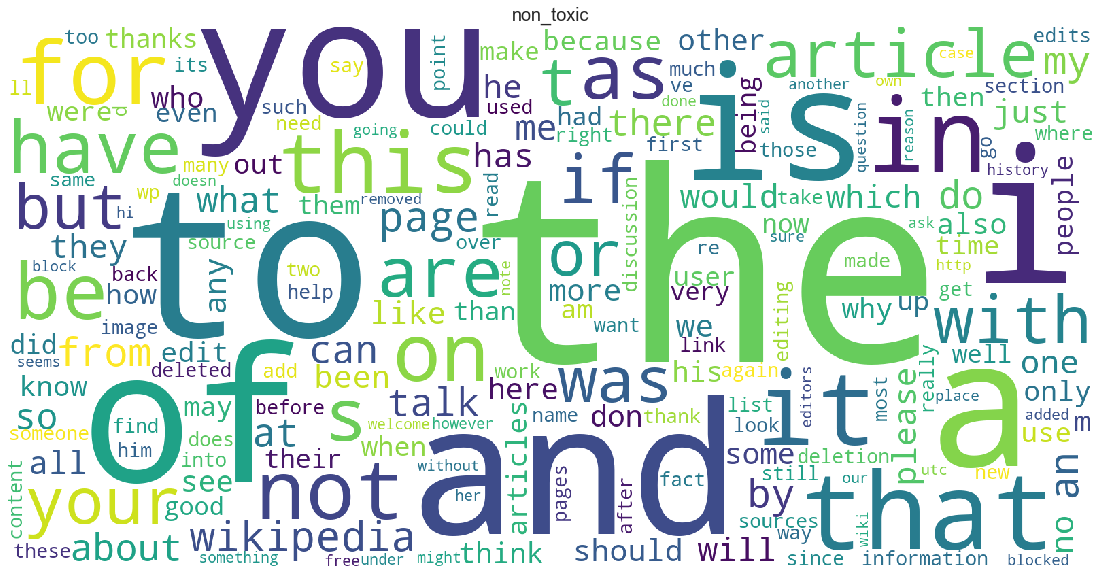

In [20]:
from wordcloud import WordCloud

# Before removing stopwords
# logomask = imread('Wikipedia.png')
for word in word_counter:
    wc = word_counter[word]

    wordcloud = WordCloud(
          background_color='white',
#           mask = logomask,
           width=1600, 
           height=800,
           random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(20,10), facecolor = 'white')
    plt.title(word)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

## Word Cloud on cleaned text

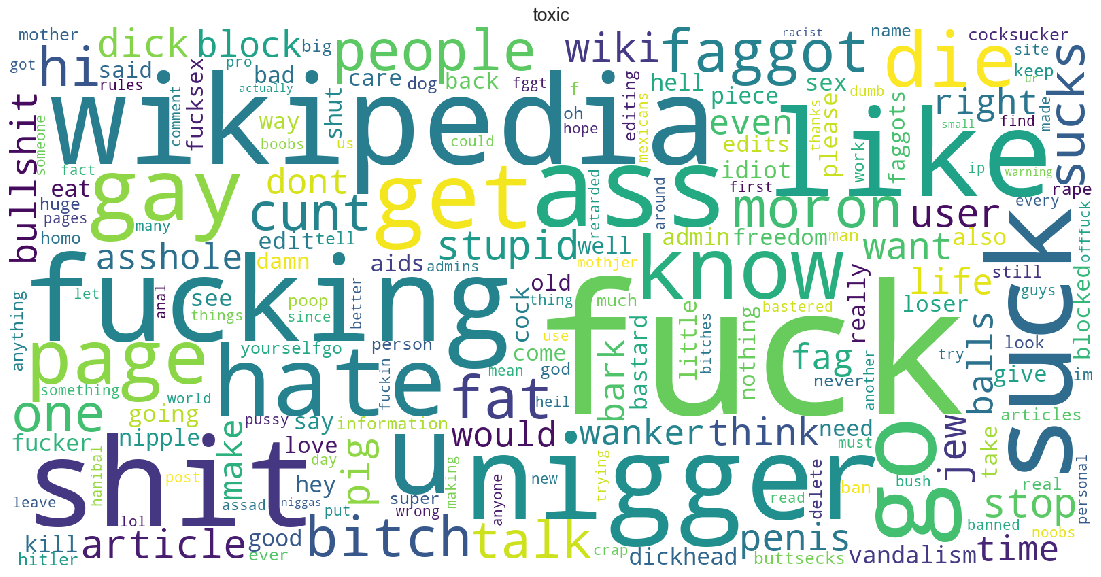

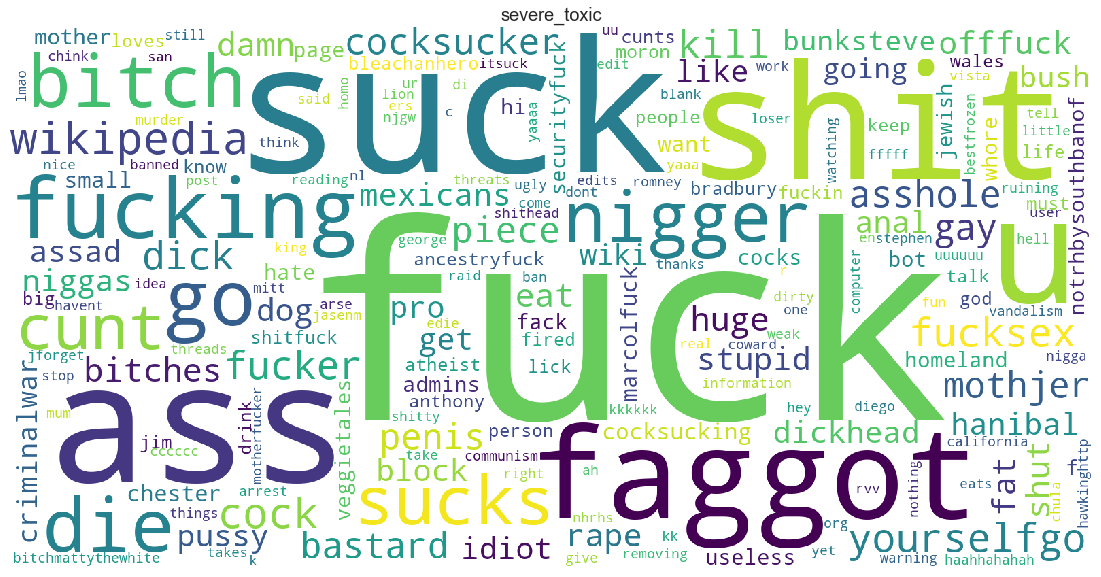

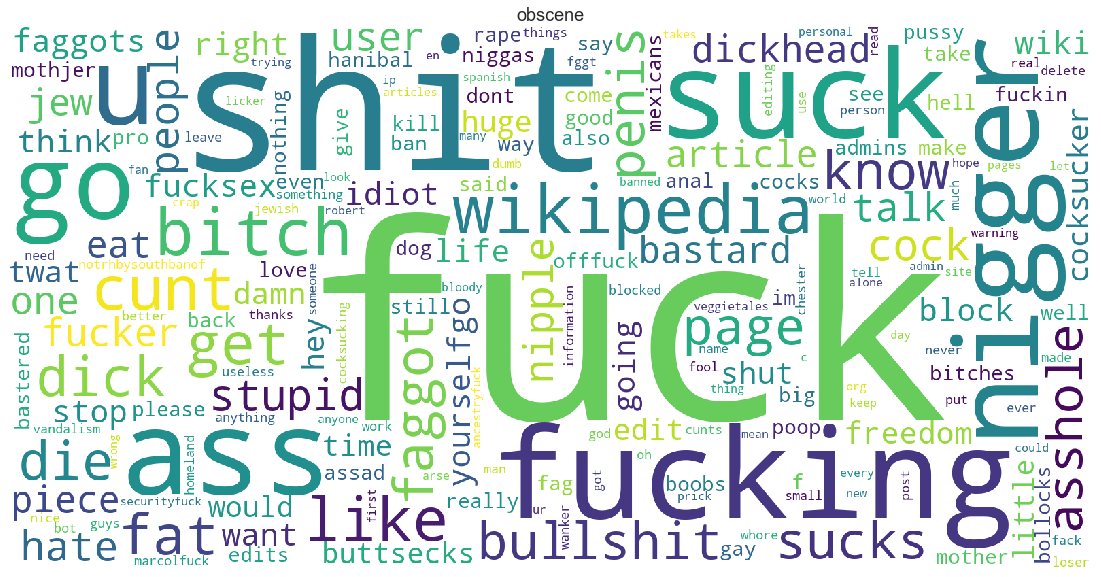

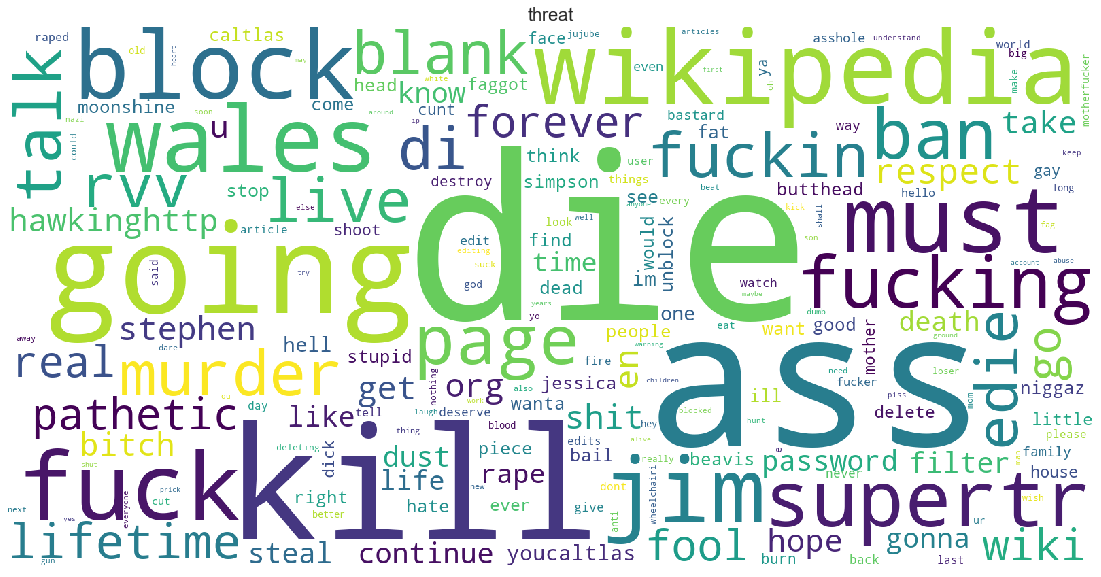

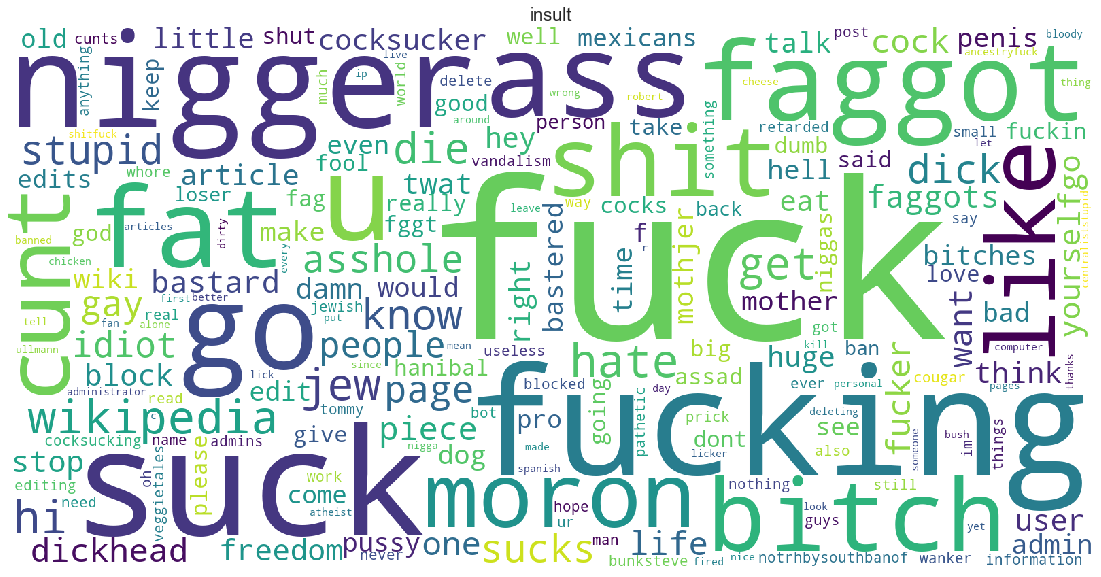

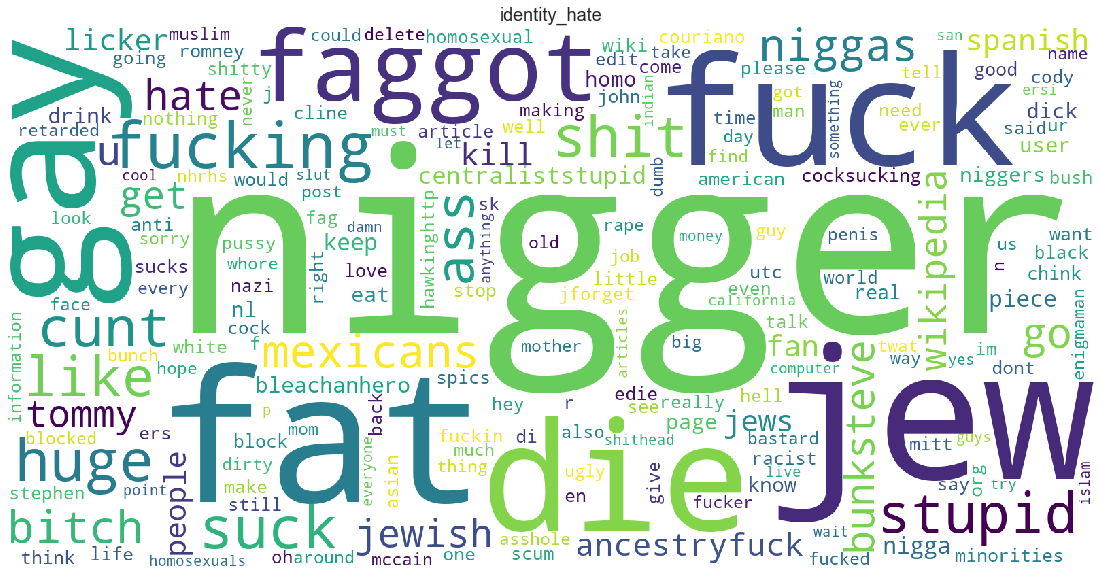

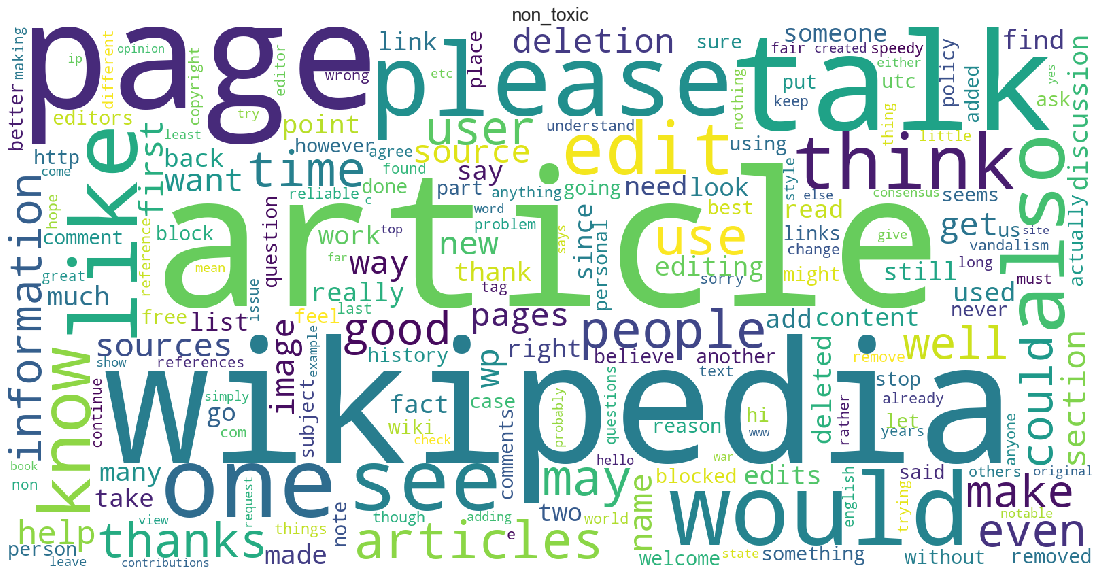

In [21]:
# After removing stopwords
word_counter = {}
stop = stopwords.words('english')

def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

toxicity = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
for categ in toxicity:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)
    
for word in word_counter:
    wc = word_counter[word]

    wordcloud = WordCloud(
          background_color='white',
           width=1600, 
           height=800,
           random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(30, 10), facecolor = 'white')
    plt.title(word)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

## Readability 

In [22]:
# Readability
from textstat import textstat
toxicity = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
df_train = pd.read_csv('train.csv')
rowsums=df_train.iloc[:,2:].sum(axis=1)
df_train['non_toxic']=(rowsums==0).astype(int)

text = df_train['comment_text'].str.cat()

print('Flesch Reading Ease Score:', textstat.flesch_reading_ease(text))
print('SMOG Index:', textstat.smog_index(text))
print('Flesch Reading Grade:', textstat.flesch_kincaid_grade(text))
print('Coleman Liau Index:', textstat.coleman_liau_index(text))
print('Automated Readability Index:', textstat.automated_readability_index(text))
print('Dale-Chall Readability Score:', textstat.dale_chall_readability_score(text))

print('Linsear Write Formula:', textstat.linsear_write_formula(text))
print('Gunning Fog:', textstat.gunning_fog(text))
print('Text Standard:', textstat.text_standard(text))
print('The number of difficult words:', textstat.difficult_words(text))




Flesch Reading Ease Score: 47.46
SMOG Index: 14.1
Flesch Reading Grade: 14.6
Coleman Liau Index: 10.75
Automated Readability Index: 18.0
Dale-Chall Readability Score: 1.81
Linsear Write Formula: 7.857142857142858
Gunning Fog: 13.06
Text Standard: 14th and 15th grade
The number of difficult words: 147360


## View the respective score for each category

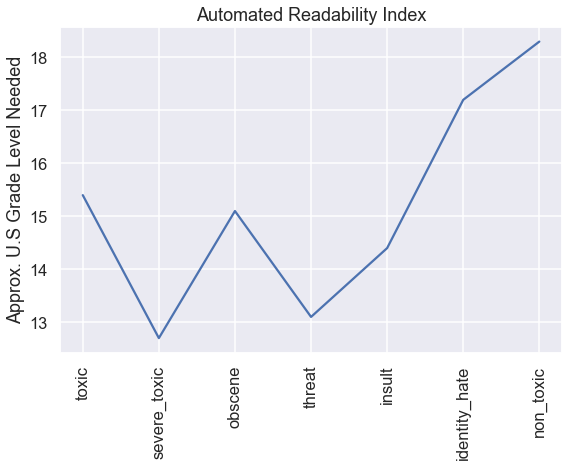

In [23]:
toxic_text = df_train[df_train['toxic'] == 1]['comment_text'].str.cat()
severe_toxic_text = df_train[df_train['severe_toxic'] == 1]['comment_text'].str.cat()
obscene_text = df_train[df_train['obscene'] == 1]['comment_text'].str.cat()
threat_text = df_train[df_train['threat'] == 1]['comment_text'].str.cat()
insult_text = df_train[df_train['insult'] == 1]['comment_text'].str.cat()
identity_hate_text = df_train[df_train['identity_hate'] == 1]['comment_text'].str.cat()
non_toxic_text = df_train[df_train['non_toxic'] == 1]['comment_text'].str.cat()
score = textstat.automated_readability_index(text)
score_toxic = textstat.automated_readability_index(toxic_text)
score_severe_toxic = textstat.automated_readability_index(severe_toxic_text)
score_obscene = textstat.automated_readability_index(obscene_text)
score_threat = textstat.automated_readability_index(threat_text)
score_insult = textstat.automated_readability_index(insult_text)
score_identity_hate = textstat.automated_readability_index(identity_hate_text)
score_non_toxic = textstat.automated_readability_index(non_toxic_text)

score_summary = [score_toxic, score_severe_toxic, score_obscene, score_threat, score_insult, score_identity_hate, score_non_toxic]

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
ax = sns.lineplot(x=toxicity, y=score_summary, sort=False)
plt.ylabel('Approx. U.S Grade Level Needed')
plt.title('Automated Readability Index')
plt.show()

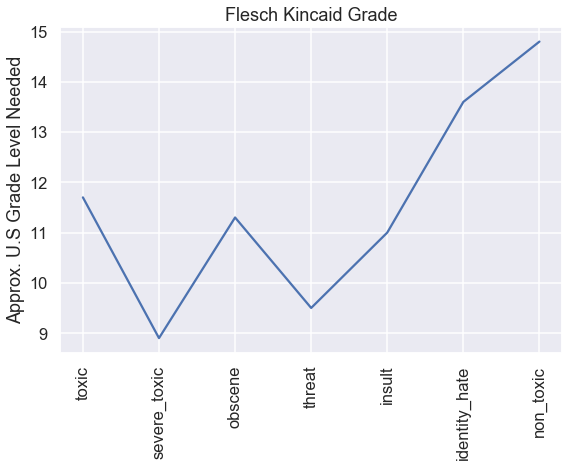

In [24]:

score_toxic = textstat.flesch_kincaid_grade(toxic_text)
score_severe_toxic = textstat.flesch_kincaid_grade(severe_toxic_text)
score_obscene = textstat.flesch_kincaid_grade(obscene_text)
score_threat = textstat.flesch_kincaid_grade(threat_text)
score_insult = textstat.flesch_kincaid_grade(insult_text)
score_identity_hate = textstat.flesch_kincaid_grade(identity_hate_text)
score_non_toxic = textstat.flesch_kincaid_grade(non_toxic_text)

score_summary = [score_toxic, score_severe_toxic, score_obscene, score_threat, score_insult, score_identity_hate, score_non_toxic]

plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
ax = sns.lineplot(x=toxicity, y=score_summary, sort=False)
plt.ylabel('Approx. U.S Grade Level Needed')
plt.title('Flesch Kincaid Grade')
plt.show()

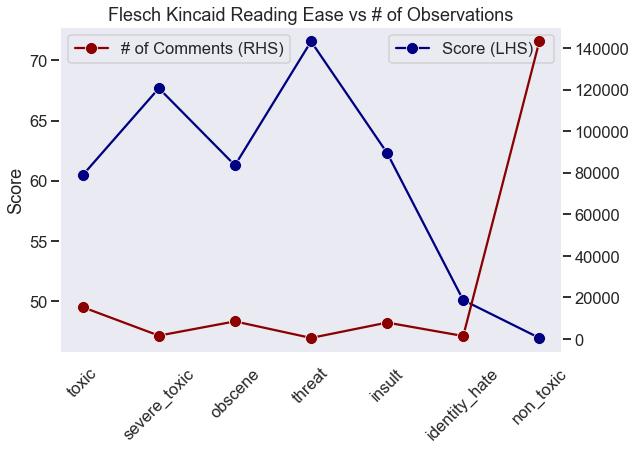

In [25]:

score_toxic = textstat.flesch_reading_ease(toxic_text)
score_severe_toxic = textstat.flesch_reading_ease(severe_toxic_text)
score_obscene = textstat.flesch_reading_ease(obscene_text)
score_threat = textstat.flesch_reading_ease(threat_text)
score_insult = textstat.flesch_reading_ease(insult_text)
score_identity_hate = textstat.flesch_reading_ease(identity_hate_text)
score_non_toxic = textstat.flesch_reading_ease(non_toxic_text)

score_summary = [score_toxic, score_severe_toxic, score_obscene, score_threat, score_insult, score_identity_hate, score_non_toxic]

count_num=[]

for name in toxicity:
    count_num.append(df_train[name].sum())

plt.figure(figsize=(9,6))
plt.xticks(rotation=45)
ax = sns.lineplot(x=toxicity, y=score_summary, marker = 'o', markersize=12, label = 'Score (LHS)   ', color = 'navy', sort=False)
ax.grid(False)
plt.ylabel('Score')
ax2 = plt.twinx()
ax2.grid(False)
plt.title('Flesch Kincaid Reading Ease vs # of Observations')
sns.lineplot(x=toxicity, y=count_num, marker = 'o', markersize=12, label = '# of Comments (RHS)', color="darkred", ax=ax2, sort = False)
plt.show()